In [53]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, Data

In [32]:
df = pd.read_csv("nwsl/2023_2024_movement.csv")
df = df.set_index("player").join(
    Data.get_nwsl_player_stats(season="2023")[["player", "mins_played"]]
    .groupby("player")
    .sum()
).sort_values("mins_played")
df

,team_old,team_new,mins_played
player,,,
Mackenzie Pluck,LA,NaN,1.0
Mia Gyau,SD,NaN,1.0
Addie McCain,CHI,NaN,1.0
Sabrina Flores,NJNY,NaN,1.0
Marley Canales,RGN,NaN,3.0
...,...,...,...
Thais Reiss,ORL,NaN,NaN
Tori Hansen,ORL,ORL,NaN
Vanessa Gilles,LA,LA,NaN


In [34]:
# To confirm if players are missing
# missing_minutes = set(df[df["mins_played"].isna()].index)
# signed = set(pd.read_csv("nwsl/signed.csv")["player"])
# missing_minutes - signed

In [36]:
df = df.dropna(subset=["mins_played", "team_new"])
df

,team_old,team_new,mins_played
player,,,
Jyllissa Harris,HOU,HOU,7.0
Amanda Allen,ORL,ORL,9.0
Shea Groom,HOU,CHI,11.0
Madelyn Desiano,HOU,HOU,20.0
Angelina,RGN,ORL,33.0
...,...,...,...
Lauren Milliet,LOU,LOU,1980.0
Katie Lund,LOU,LOU,1980.0
Sarah Gorden,LA,LA,1980.0


In [40]:
df_agg = (
    df.reset_index().drop(columns=["player"]).groupby(["team_new", "team_old"]).sum()
)
df_agg

mins_played
team_new team_old             
BAY      CHI             695.0
         HOU            3016.0
         KC              796.0
         LA              912.0
         NC             1603.0
...                        ...
UTA      POR             812.0
         SD             2410.0
WAS      CHI            1711.0
         NC              367.0
         WAS           14307.0

[61 rows x 1 columns]

In [96]:
df_total = (
    df.groupby("team_new")
    .agg(total_mins=("mins_played", "sum"))
    .sort_values("total_mins", ascending=False)
)
df_total

,total_mins
team_new,
NJNY,24551.0
NC,22027.0
LA,19475.0
LOU,19228.0
SD,18674.0
HOU,18563.0
ORL,17116.0
WAS,16385.0
RGN,16205.0


In [109]:
df_self = df_agg.reset_index()
df_self = df_total.join(
    df_self[df_self["team_new"] == df_self["team_old"]].set_index("team_new")
).reset_index()[["team_old", "team_new", "mins_played", "total_mins"]]
df_self.loc[df_self["team_new"] == "BAY", "team_old"] = "BAY"
df_self.loc[df_self["team_new"] == "UTA", "team_old"] = "UTA"
df_self = df_self.fillna(0)
df_self

,team_old,team_new,mins_played,total_mins
0,NJNY,NJNY,15998.0,24551.0
1,NC,NC,16962.0,22027.0
2,LA,LA,16916.0,19475.0
3,LOU,LOU,16007.0,19228.0
4,SD,SD,16114.0,18674.0
5,HOU,HOU,14527.0,18563.0
6,ORL,ORL,16787.0,17116.0
7,WAS,WAS,14307.0,16385.0
8,RGN,RGN,15040.0,16205.0
9,POR,POR,15502.0,15766.0


In [110]:
def get_data_for_team(old_team):
    result = []
    for team in df_self["team_new"]:
        if (team, old_team) in df_agg.index and team != old_team:
            result.append(df_agg.loc[(team, old_team), "mins_played"])
        else:
            result.append(0)
    return result

<ipython-input-134-562ed3ba890e>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "5k", "10k", "15k", "20k", "25k"])


<Figure size 6400x4000 with 0 Axes>

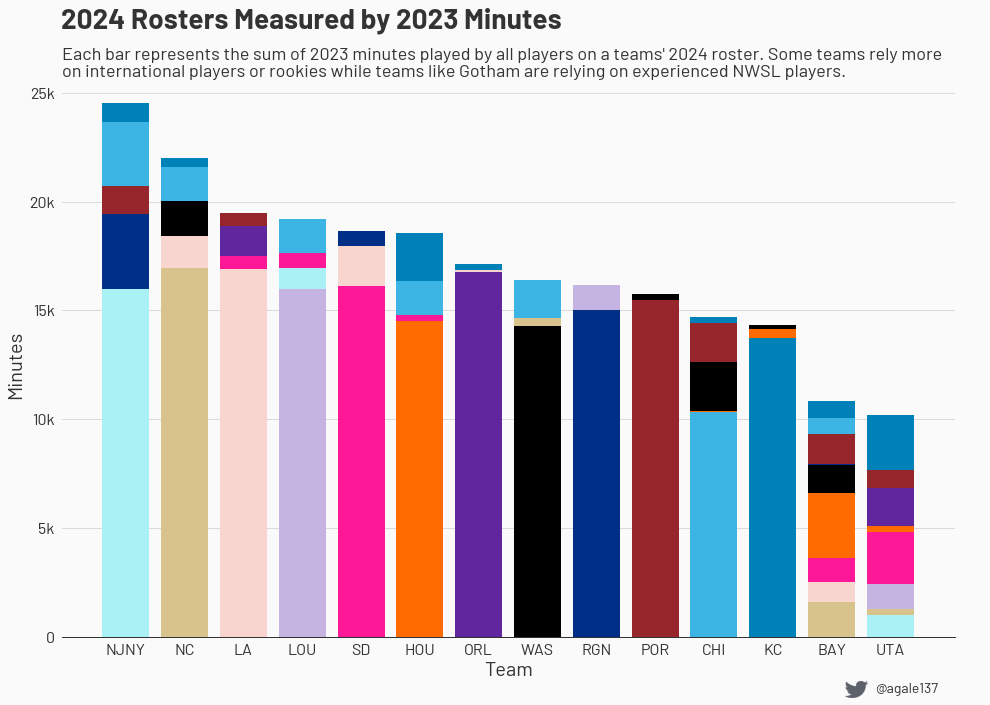

In [134]:
# Set up plot
plt.rcParams["figure.figsize"] = (16, 10)
plt.figure(dpi=400)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data

# Start with the home team data
bottom = np.zeros(len(df_self.index))
plt.bar(
    df_self["team_new"],
    df_self["mins_played"],
    color=list(map(lambda x: NWSL.color(x), df_self["team_old"])),
    bottom=bottom,
)
bottom += df_self["mins_played"]

# Render all other teams on top
for team in df_self["team_old"]:
    minutes = get_data_for_team(team)
    plt.bar(
        df_self["team_new"],
        minutes,
        color=list(map(lambda x: NWSL.color(team), minutes)),
        bottom=bottom,
    )
    bottom += minutes

# Axes
ax.set_ylim([0, 25000])
ax.set_yticklabels(["0", "5k", "10k", "15k", "20k", "25k"])
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color=Colors.LIGHT_GRAY)
ax.set_axisbelow(True)
ax.tick_params(axis="both", which="major", labelsize=16, labelcolor=Colors.BLACK)
for label in ax.get_yticklabels() + ax.get_xticklabels():
    fp = Fonts.BARLOW
    fp.set_size(16)
    label.set_fontproperties(fp)

# Axis labels
ax.set_xlabel(
    "Team",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=20,
)
ax.set_ylabel(
    "Minutes",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=20,
)

# Title
ax.text(
    -1.1,
    28000,
    "2024 Rosters Measured by 2023 Minutes",
    fontproperties=Fonts.BARLOW_BOLD,
    color=Colors.BLACK,
    size=28,
    ha="left",
)

# Subtitle
fig.text(
    0,
    1.03,
    "Each bar represents the sum of 2023 minutes played by all players on a teams' 2024 roster. Some teams rely more\non international players or rookies while teams like Gotham are relying on experienced NWSL players.",
    fontproperties=Fonts.BARLOW,
    size=18,
    transform=ax.transAxes,
    ha="left",
    color=Colors.BLACK,
)

# Twitter logo and username
add_twitter_handle(fig, x=0.8, y=0.04, fs=14, w=0.025)